In [16]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [17]:
spark = SparkSession.builder.getOrCreate()

 # Task 1 - Part 1

In [18]:
#Task 1 - Part 1
def clean_data(df):
    #Takes in a pyspark dataframe
    #Counts number of entries before and after dropping duplicates,
    #nulls and missing values.
    print(f'Original count: {df.count()}')
    df = df.dropDuplicates()
    df = df.dropna()
    print(f'Count after cleaning: {df.count()}')
    return df

df = spark.read.csv('nuclear_plants_small_dataset.csv',inferSchema=True,header=True)
df.printSchema()
df = clean_data(df)


root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3 : double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure_sensor_1: double (nullable = true)
 |-- Pressure_sensor_2: double (nullable = true)
 |-- Pressure_sensor_3: double (nullable = true)
 |-- Pressure_sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)

Original count: 996
Count after cleaning: 996


# Task 1 - Part 2 and 3

In [19]:
#Task 1 - Part 2 and 3

def filter_df(df):
    #Filters dataframe by normal and abnormal groups
    #Returns two dataframes, one for each group.
    normal_df = df.filter(df['Status'] == 'Normal')
    abnormal_df = df.filter(df['Status'] == 'Abnormal')

    return normal_df, abnormal_df


def summary_stats(df):
    #Takes in pyspark dataframe
    #Drops the status column and uses .summary to find mean min max and median
    #Then converts to a pandas dataframe.
    
    normal_df, abnormal_df = filter_df(df)


    dfSummaryNormal = normal_df.drop('Status').summary('mean','min','max','50%')
    dfSummaryNormal = dfSummaryNormal.withColumnRenamed('summary', 'Feature')
    
    
    dfSummaryAbnormal = abnormal_df.drop('Status').summary('mean','min','max','50%')
    dfSummaryAbnormal = dfSummaryAbnormal.withColumnRenamed('summary', 'Feature')
    
    
    return dfSummaryNormal, dfSummaryAbnormal


def boxplot_df(df):
    #Takes in pyspark dataframe filters to normal and abnormal groups, converts to pandas dataframe
    #and plots a boxplot for each feature in each group.

    #Filter the dataframe by normal and abnormal groups
    normal_df, abnormal_df = filter_df(df)

    if normal_df:
        normal_df = normal_df.toPandas()
        #Drop the status column
        normal_df.drop('Status',axis=1,inplace=True)
        plt.figure(figsize=(25,10))
        sns.boxplot(data=normal_df)
        plt.ylabel('Values')
        plt.xlabel('Features')
        plt.title('Boxplot for Normal Group')
        plt.show()
    if abnormal_df:
        abnormal_df = abnormal_df.toPandas()
        #Drop the status column
        abnormal_df.drop('Status',axis=1,inplace=True)
        plt.figure(figsize=(25,10))
        sns.boxplot(data=abnormal_df)
        plt.ylabel('Values')
        plt.xlabel('Features')
        plt.title('Boxplot for Abnormal Group')
        plt.show()

In [20]:
summaryNormal, summaryAbnormal = summary_stats(df)
print('Normal group summary statistics:')
summaryNormal = summaryNormal.toPandas()
print(summaryNormal.T)
#summaryNormal.show()

Normal group summary statistics:
                                        0       1        2        3
Feature                              mean     min      max      50%
Power_range_sensor_1    5.602452811244987  0.0851  12.1298   5.1727
Power_range_sensor_2    6.844503413654614  0.0403  11.9284   6.6998
Power_range_sensor_3    9.292054016064252  4.3826  14.0982   9.2624
Power_range_sensor_4    8.701398192771098  0.1547  16.3568   9.2404
Pressure_sensor_1      13.797525502008027  0.0248  56.8562  10.6274
Pressure_sensor_2      3.4156463855421686  0.0104   9.2212    3.113
Pressure_sensor_3       5.923352610441763  0.0774  12.6475   5.7394
Pressure_sensor_4       5.586180120481918  0.0058  15.1085   4.2574
Vibration_sensor_1      8.441436947791164  0.0092  31.4981   7.4222
Vibration_sensor_2      9.699615863453817  0.0277  34.8676   8.6684
Vibration_sensor_3       19.4378044176707  0.0646  53.2384  16.4414
Vibration_sensor_4     10.925097590361458  0.0831  43.2314   9.4347


In [21]:
print('Abnormal group summary statistics:')
summaryAbnormal = summaryAbnormal.toPandas()
print(summaryAbnormal.T)
#summaryAbnormal.show()

Abnormal group summary statistics:
                                        0         1          2         3
Feature                              mean       min        max       50%
Power_range_sensor_1    4.396694975903618    0.0082  10.923078    4.5053
Power_range_sensor_2    5.914042891566265    0.3891    10.1541  5.929872
Power_range_sensor_3    9.164170212851404  2.583966    15.7599    9.4666
Power_range_sensor_4    6.009145979919678    0.0623  17.235858    5.3952
Pressure_sensor_1      14.600728132530127  0.131478    67.9794   12.5912
Pressure_sensor_2      2.7402695381526136  0.008262  10.242738  2.380578
Pressure_sensor_3      5.5751150803212886  0.001224    11.7724  5.743314
Pressure_sensor_4        4.40782413253012  0.029478   16.55562    3.3072
Vibration_sensor_1      7.887688803212858       0.0  36.186438    6.5175
Vibration_sensor_2      10.30356990763052    0.0185  34.331466    8.9085
Vibration_sensor_3     10.938158947791155  0.131784  36.911454  8.983038
Vibration_sensor

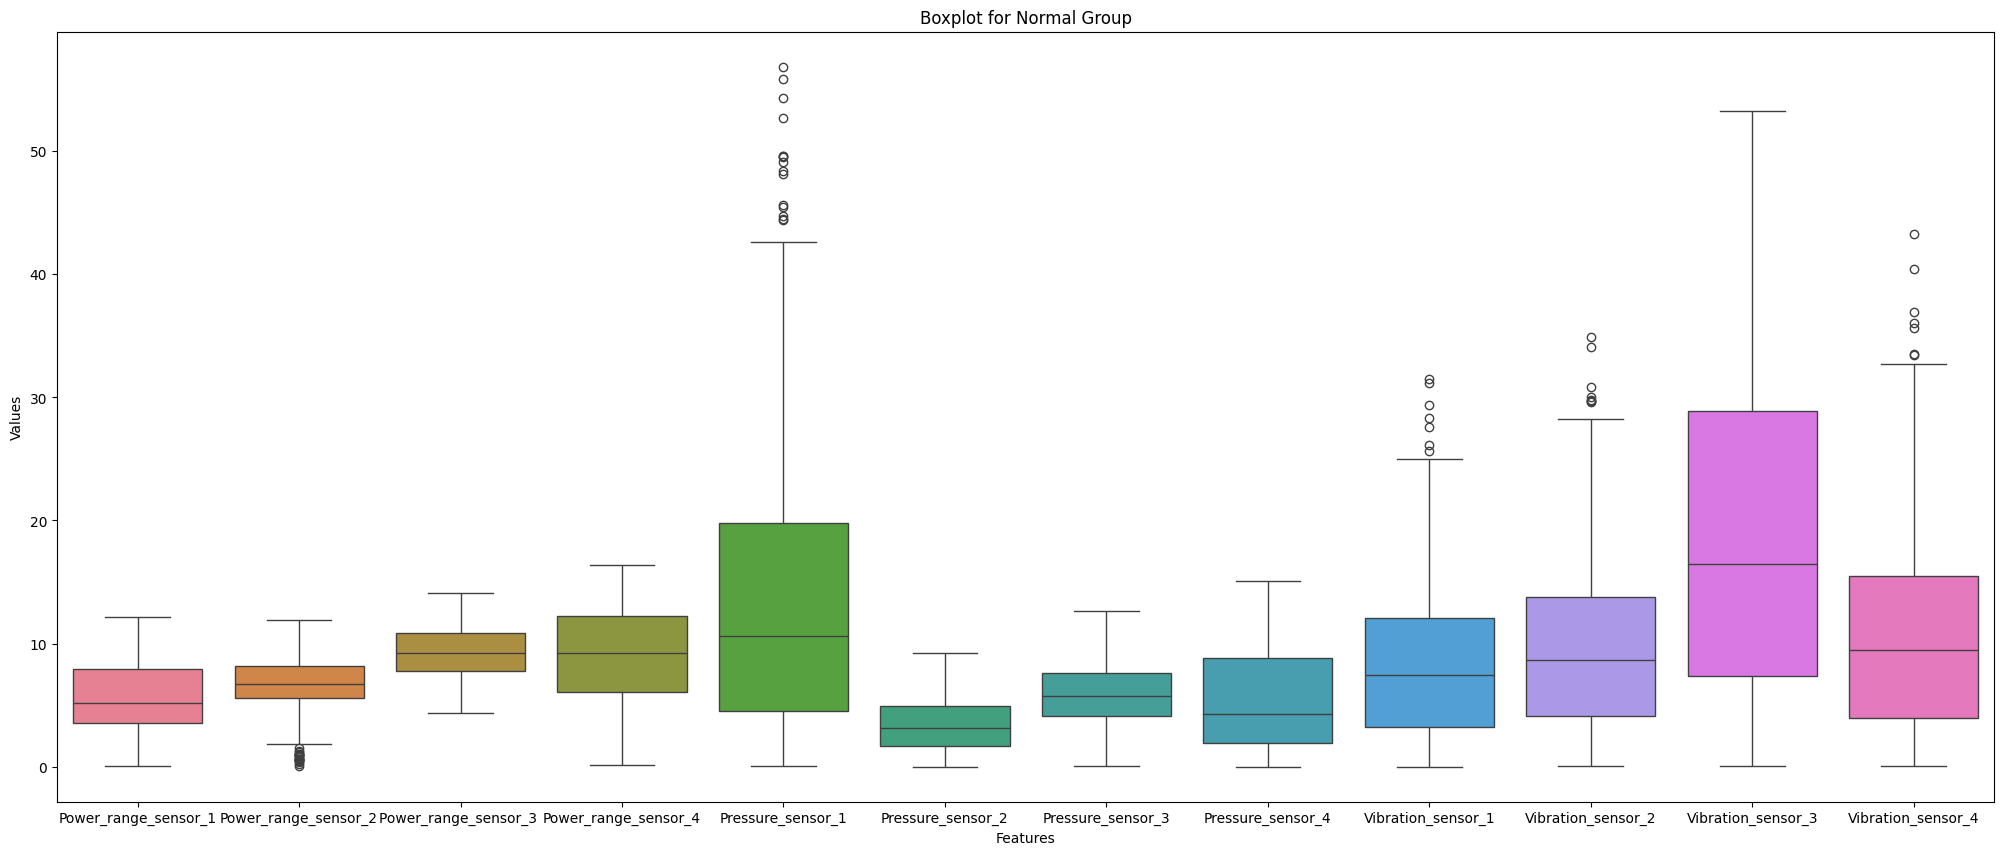

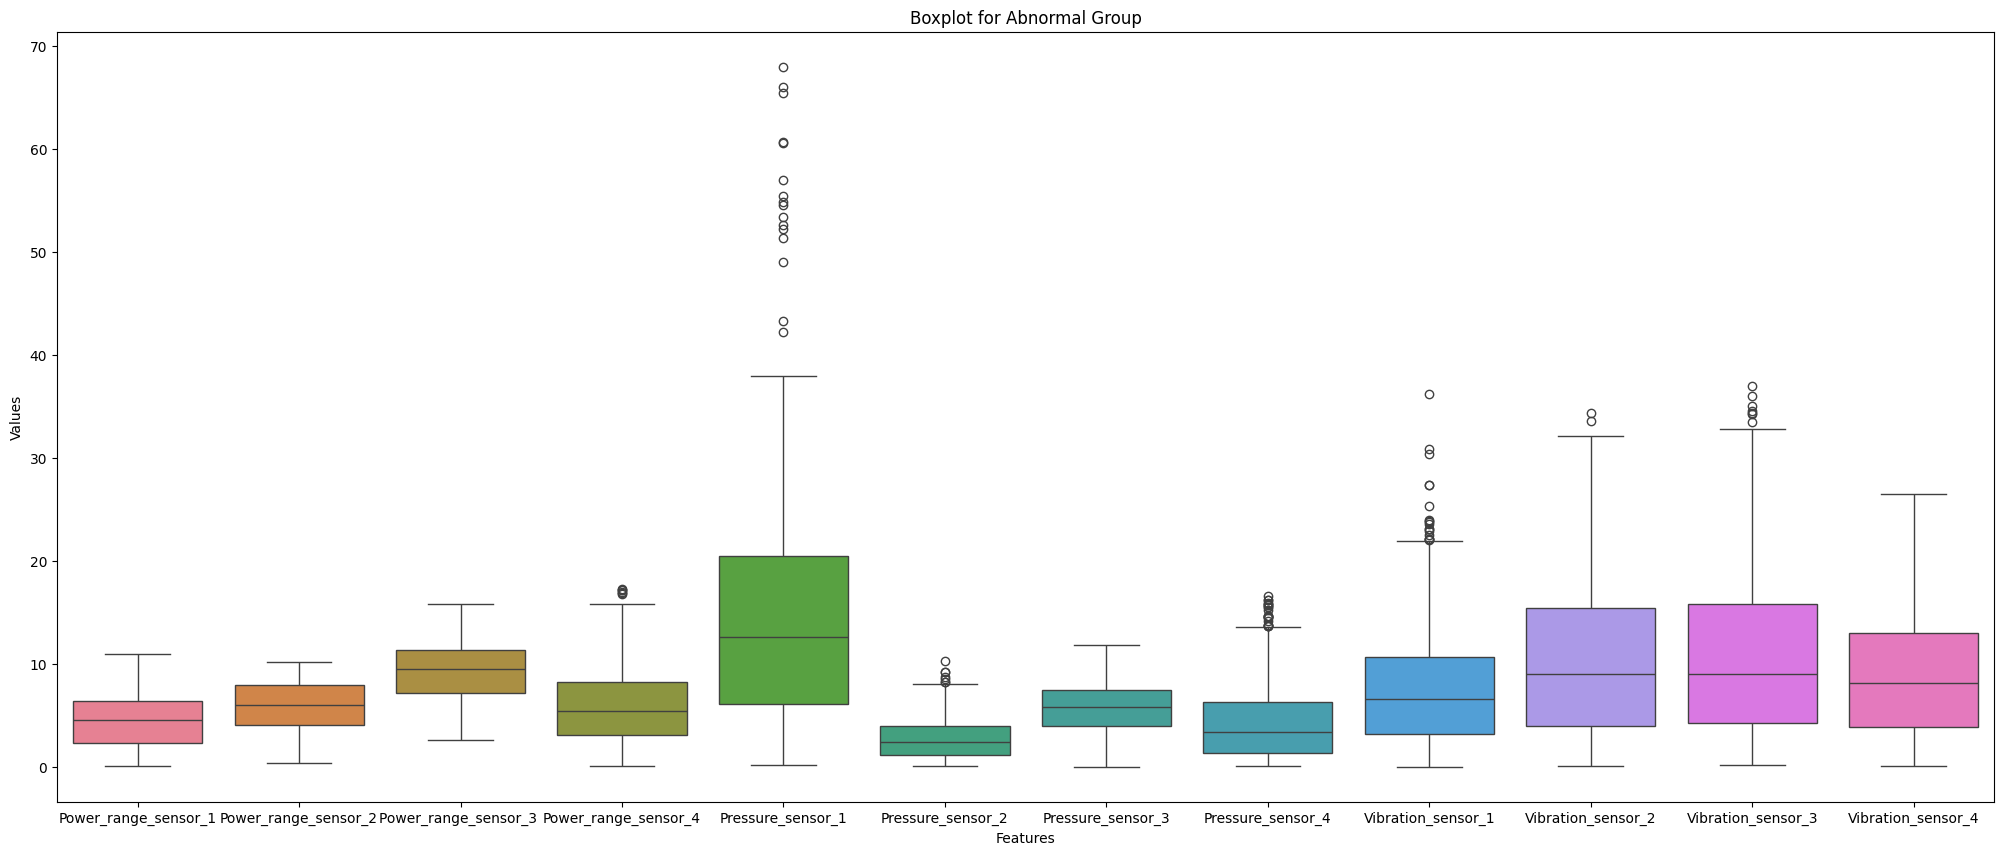

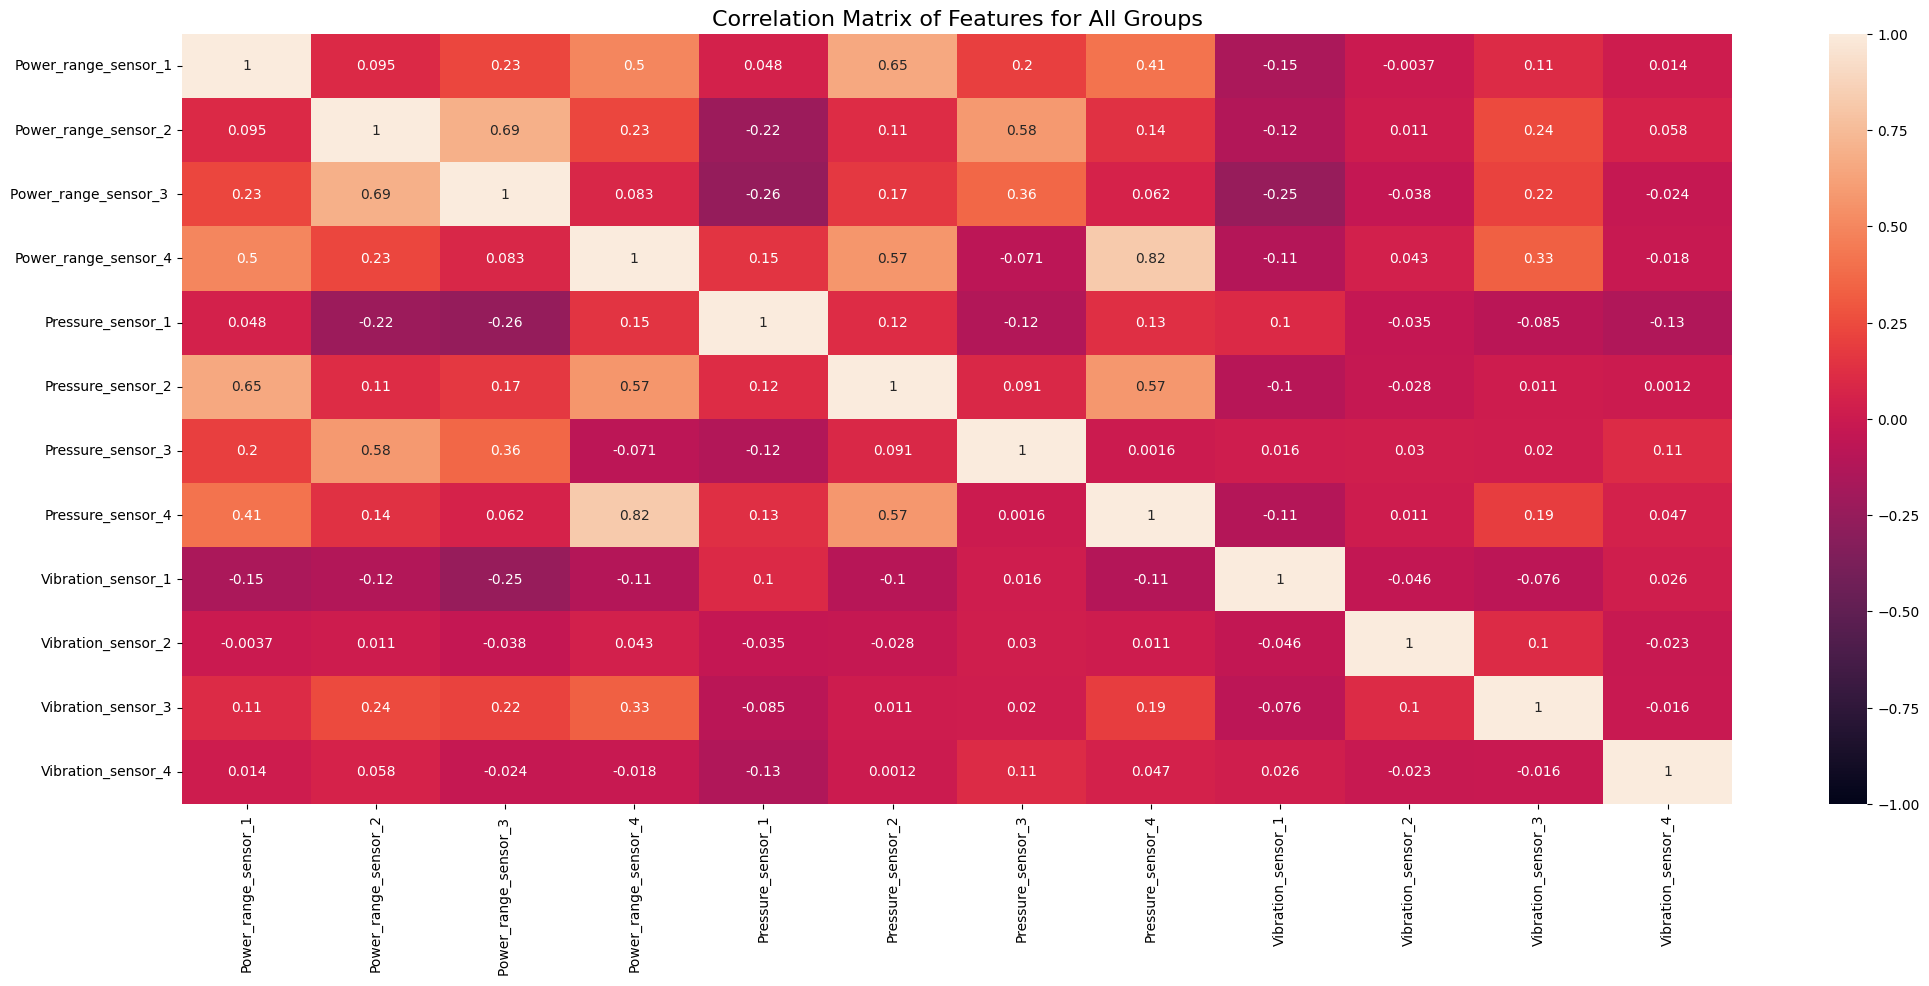

In [22]:
#Boxplots for each group
boxplot_df(df)

#Correlation Matrix creation and show
df_dropped = df.drop('Status').toPandas()
df_corr = df_dropped.corr(method='pearson')
plt.figure(figsize=(25,10))
plt.title('Correlation Matrix of Features for All Groups',y=1,size=16)
sns.heatmap(df_corr,annot = True, vmin=-1, vmax=1)
plt.show()

# Task 2 - Part 1

In [23]:
#Task 2 - Map Reduce
from pyspark import SparkContext
from operator import add, sub
sc = SparkContext.getOrCreate()
#Task 2 - Part 1

airport_names = spark.read.csv('Top30_airports_LatLong.csv',inferSchema=True,)
airport_names = airport_names.withColumnRenamed('_c0','airportName')\
        .withColumnRenamed('_c1','Code')\
        .withColumnRenamed('_c2','Latitude')\
        .withColumnRenamed('_c3','Longitude')

passenger_data = spark.read.csv('AComp_Passenger_data_no_error.csv',inferSchema=True)
passenger_data = passenger_data.withColumnRenamed('_c0','passengerID')\
        .withColumnRenamed('_c1','flightID')\
        .withColumnRenamed('_c2','Origin_Code')\
        .withColumnRenamed('_c3','Destination_Code')\
        .withColumnRenamed('_c4','departureTime_GMT')\
        .withColumnRenamed('_c5','totalFlightTime_mins')


#Count the number of flights from each airport
passenger_data_rdd = sc.parallelize(passenger_data.collect(), 1)
#Get airport code and give it a key value of 1
passenger_data_flights = passenger_data_rdd.map(lambda col: (col['Origin_Code'],1)).reduceByKey(add)
#passenger_data_flights = passenger_data_flights.reduceByKey(lambda x,y: x+y)
passenger_data_flights = passenger_data_flights.sortBy(lambda col: col[1],ascending=False)
passenger_data_flights = passenger_data_flights.toDF(['Code','Number of Flights'])
#Join the airport names to the code and number of flights
passenger_data_flights = passenger_data_flights.join(airport_names.select('Code','airportName'), "Code", how='inner')
print('Number of flights from each airport:')
passenger_data_flights.show()

Number of flights from each airport:
+----+-----------------+------------+
|Code|Number of Flights| airportName|
+----+-----------------+------------+
| DEN|               46|      DENVER|
| CAN|               37|   GUANGZHOU|
| IAH|               37|     HOUSTON|
| ATL|               36|     ATLANTA|
| ORD|               33|     CHICAGO|
| KUL|               33|KUALA LUMPUR|
| CGK|               27|     JAKARTA|
| JFK|               25|    NEW YORK|
| LHR|               25|      LONDON|
| CDG|               21|       PARIS|
| CLT|               21|   CHARLOTTE|
| PVG|               20|    SHANGHAI|
| LAS|               17|   LAS VEGAS|
| BKK|               17|     BANGKOK|
| AMS|               15|   AMSTERDAM|
| FCO|               15|        ROME|
| MUC|               14|      MUNICH|
| MAD|               13|      MADRID|
| PEK|               13|     BEIJING|
| HND|               13|       TOKYO|
+----+-----------------+------------+
only showing top 20 rows



In [24]:
#Create a list of unused airports 
airport_rdd = sc.parallelize(airport_names.collect(), 1)
# Extract the airport codes from the passenger data ensuring to check origin and destination codes.
used_airports = passenger_data_rdd.flatMap(lambda col: [col[2], col[3]]).distinct()

# Extract all airport codes from the airport data
all_airports = airport_rdd.map(lambda col: col[1])

# Find unused airports using the subtract operation
unused_airports = all_airports.subtract(used_airports)
unused_airports = unused_airports.toDF(schema=StringType())
# Collect the result turn into pandas dataframe
unused_airports= unused_airports.withColumnRenamed('value','Code')
unused_airports = unused_airports.join(airport_names.select('airportName', 'Code'), 'Code', how = 'inner')


#Aiprort codes that are not used in origin or destination.
print('Airports not used in destination or origin:')
unused_airports.show()


Airports not used in destination or origin:
+----+-----------+
|Code|airportName|
+----+-----------+
| PHX|    PHOENIX|
| IST|   ISTANBUL|
+----+-----------+



In [25]:
#Airports not used as origin
origin_unused = airport_rdd.map(lambda col: (col['Code'],1))

#Get the origin codes from the passenger data
test_pass = passenger_data_rdd.map(lambda col: (col['Origin_Code'], 1))
unused = origin_unused.subtractByKey(test_pass)
unused_df = unused.toDF(['Code', 'Count'])
unused_df = unused_df.join(airport_names.select("airportName", "Code"), "Code", how = 'inner').drop('Count')


print('Airports not used in origin only')
unused_df.show()


Airports not used in origin only
+----+-------------+
|Code|  airportName|
+----+-------------+
| HKG|    HONG KONG|
| DXB|        DUBAI|
| PHX|      PHOENIX|
| IST|     ISTANBUL|
| LAX|  LOS ANGELES|
| FRA|    FRANKFURT|
| SIN|    SINGAPORE|
| SFO|SAN FRANCISCO|
+----+-------------+



# Task 2 - Part 2

In [26]:
#Task 2 - Part 2 - First check using pyspark to see what it looks like
#Create a list of flights based on the Flight id; including number of passengers, relevant IATA/FAA 
#codes, and departure and arrival times (times converted to HH:MM format) 
from datetime import datetime

#Converting to HH:MM format
def unix_to_GMT(unixtime): 
    GMT = datetime.fromtimestamp(unixtime)  
    return GMT.strftime("%H:%M")

# Function to calculate arrival time
def calculate_arrival_time(departure_time, total_flight_time):
    return departure_time + (total_flight_time * 60) 

#Calculate the number of passengers for each flight
num_passengers = passenger_data.rdd.map(lambda col: (col['flightID'], 1)).reduceByKey(add)
num_passengers = num_passengers.sortBy(lambda col: col[1], ascending=False)
num_passengers_df = num_passengers.toDF(['flightID', 'PassengerCount'])


passenger_count = passenger_data.groupBy("flightID", "Origin_Code", "Destination_Code").agg(
        F.first("departureTime_GMT").alias("departureTime_GMT"),
        F.first("totalFlightTime_mins").alias("totalFlightTime_mins")
)

passenger_count = passenger_count.join(num_passengers_df, "flightID", how = "inner")

# Convert DataFrame to RDD
passenger_count_rdd = sc.parallelize(passenger_count.collect(), 1)


#Transform the RDD by calculating the arrival time and converting the unix time to HH:MM format
passenger_count_rdd_transformed = passenger_count_rdd.map(lambda col: (
    col["flightID"],
    col["Origin_Code"],
    col["Destination_Code"],
    col["PassengerCount"],
    unix_to_GMT(col["departureTime_GMT"]),
    unix_to_GMT(calculate_arrival_time(col["departureTime_GMT"], col["totalFlightTime_mins"])))
)
# Convert RDD back to DataFrame
passenger_count_transformed_df = passenger_count_rdd_transformed.toDF(["flightID", "Origin Code", "Destination Code", "Passenger Count", "Departure Time", "Arrival Time"])

# Show the resulting DataFrame
passenger_count_transformed_df.show()

+--------+-----------+----------------+---------------+--------------+------------+
|flightID|Origin Code|Destination Code|Passenger Count|Departure Time|Arrival Time|
+--------+-----------+----------------+---------------+--------------+------------+
|ULZ8130D|        CAN|             DFW|             27|         17:23|       21:26|
|XXQ4064B|        JFK|             FRA|             25|         17:05|       06:27|
|GMO5938W|        LHR|             PEK|             25|         17:11|       10:48|
|KJR6646J|        IAH|             BKK|             23|         17:26|       01:34|
|SQU6245R|        DEN|             FRA|             21|         17:14|       10:43|
|QHU1140O|        CDG|             LAS|             21|         17:14|       12:07|
|WSK1289Z|        CLT|             DEN|             21|         16:59|       21:37|
|FYL5866L|        ATL|             HKG|             20|         17:25|       22:36|
|JVY9791G|        PVG|             FCO|             20|         17:16|      

# Task 2 - Part 3

In [27]:
#Task 2 - Part 3
# Calculate the line-of-sight (nautical) miles for each flight and the total travelled by each passenger, 
#then output the passenger having earned the highest air miles
from math import radians, cos, sin, atan2, sqrt
EARTH_RADIUS = 6371 #in km

#Function to calculate the nautical miles
def nautical_miles(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2= float(lat1), float(lon1), float(lat2), float(lon2)
    lat1, lon1, lat2, lon2 = radians(lat1), radians(lon1), radians(lat2), radians(lon2)
    deltalat = lat2 - lat1
    deltalon = lon2 - lon1
    a = sin(deltalat/2)*sin(deltalat/2)+cos(lat1)*cos(lat2) \
        *sin(deltalon/2)*sin(deltalon/2)
    c = 2*atan2(sqrt(a),sqrt(1-a))
    distance = EARTH_RADIUS*c
    return distance/1.852 #convert to nautical miles from km

origin_flightid = passenger_data.select('Origin_Code', 'flightID')
dest_flightid = passenger_data.select('Destination_Code', 'flightID')
airport_data = airport_names.select('Code', 'Latitude', 'Longitude')

#Join the origin and destination flight ids with the airport data to get the latitude and longitude
joined_origin_flightid = origin_flightid.join(airport_data, origin_flightid.Origin_Code == airport_data.Code).withColumnRenamed('Latitude', 'Origin_Latitude')\
                                                                                                            .withColumnRenamed('Longitude', 'Origin_Longitude').drop('Code')

joined_dest_flightid = dest_flightid.join(airport_data, dest_flightid.Destination_Code == airport_data.Code).withColumnRenamed('Latitude', 'Destination_Latitude')\
                                                                                                            .withColumnRenamed('Longitude', 'Destination_Longitude').drop('Code')

#Join the origin and destination flight ids together to get the flight ids with both origin and destination latitudes and longitudes.
combined = joined_origin_flightid.join(joined_dest_flightid, 'flightID', how = 'inner').distinct()
combined_rdd = sc.parallelize(combined.collect(), 1)

combined_rdd = combined_rdd.map(lambda col: (col['flightID'], col['Origin_Code'], col['Destination_Code'],
                                                        nautical_miles(col['Origin_Latitude'], col['Origin_Longitude'],
                                                                        col['Destination_Latitude'], col['Destination_Longitude'])))

#Sort by the number of nautical miles.
combined_rdd = combined_rdd.sortBy(lambda col: col[3],ascending=False)
combined_df = combined_rdd.toDF(['flightID', 'Origin Code', 'Destination Code', 'Nautical Miles'])
#Dataframe containing flight ids, origin and destination codes and nautical miles.
#combined_df.show()


#Getting flight ids, nautical miles
nautical_map = combined_rdd.map(lambda col: (col[0], col[3]))
#Getting flight ids, passenger ids
passenger_map = passenger_data_rdd.map(lambda col: (col[1], col[0]))



#Passenger with the highest air miles
#join the nautical miles with the passenger data
flight_per_passenger = nautical_map.join(passenger_map)
#print(flight_per_passenger.take(1))
#Map the passenger id to the nautical miles, reduce by key to get the total nautical miles for each passenger
flight_per_passenger = flight_per_passenger.map(lambda col: (col[1][1], col[1][0])).distinct().reduceByKey(add)
#print(flight_per_passenger.take(1))

#Sort by the number of nautical miles.
flight_per_passenger = flight_per_passenger.sortBy(lambda col: col[1],ascending=False)
flight_per_passenger = flight_per_passenger.toDF(['Passenger ID', 'Nautical Miles'])

#Passengersid with air miles
print('Passengers sorted by number of nautical miles:')
flight_per_passenger.show()



Passengers sorted by number of nautical miles:
+------------+------------------+
|Passenger ID|    Nautical Miles|
+------------+------------------+
|  UES9151GS5| 89833.78211049127|
|  SPR4484HA6| 81127.17091258784|
|  DAZ3029XA0| 80012.29925621394|
|  WBE6935NU3| 79654.77128394826|
|  HCA3158QA6| 77716.97401717158|
|  HGO4350KK1| 76642.13623633664|
|  CKZ3132BR4| 73434.54410522293|
|  PUD8209OG3|  72985.3951044363|
|  BWI0520BG6| 71648.85085949226|
|  JJM4724RF7| 69820.11402873525|
|  WYU2010YH8| 69487.07089372036|
|  YMH6360YP0| 66668.33966710874|
|  EZC9678QI6| 66504.71099104485|
|  LLZ3798PE3| 65270.54498639724|
|  CXN7304ER2| 63895.21083889411|
|  EDV2089LK5|   63767.933607232|
|  XFG5747ZT9|54765.123033087475|
|  JBE2302VO4|52779.647530868184|
|  SJD8775RZ4| 52384.71797040613|
|  MXU9187YC7| 52152.81893700002|
+------------+------------------+
only showing top 20 rows



In [28]:
#Passenger with the highest air miles
print(flight_per_passenger.show(1))

+------------+-----------------+
|Passenger ID|   Nautical Miles|
+------------+-----------------+
|  UES9151GS5|89833.78211049127|
+------------+-----------------+
only showing top 1 row

None
